# Домашняя работа 3: Разработка модели детектирования объектов

##  Кудрявцева Юлия


На семинаре мы обсудили, разработали и попробовали `SSD` модель на базе `VGG16`, поэтому для успешного выполнения домашнего задания рекомендуется обратиться к семинару.

Задачи домашнего задания:
 - Загрузить набор данных и визуализировать объекты. (2 балла)
 - Разработать функцию для расчета метрики mAP задачи детектирования объектов. Продемонстрировать работу. (4 балла)
 - Натренировать `SSD` модель на базе VGG16. Продемонстрировать повышение метрики mAP (4 балла)
 - Разработать `SSD` модель согласно предлагаемой архитектуры на базе `ResNet18`. Продемонстрировать повышение метрики mAP (10 баллов)
 - (БОНУС) Добавить разнообразные аугментации изображений. Можно позаимствовать из других репозитариев с указанием источника. Повторить эксперименты (5 баллов)

## Описание предлагаемых исходных кодов
- voc_dataset.py     - загружает предлагаемый набор данных, здесь также возможно выполнять аугментации над данными.
- voc_dataloader.py  - формирует порцию данных.
- prior_boxes.py     - содержит все необходимые функции для работы с `prior` боксами.
    - prior_boxes - функция генерирует `prior` боксы в соотвествии с конфигурацией
    - match       - функция решает задачу сопоставления `ground truth` боксов из набора данных и `prior` боксов
    - decode      - функция вычисляет поправки между `ground truth` боксами и `prior` боксами, собственно их будет *предсказывать* наша модель
    - encode      - функция пересчитывает `prior` боксы и *предсказанные* поправки в результирующие детектирования

- model_vgg16.py   - реализация `SSD` на базе VGG16, которая рассматривалась на семинаре.
- multibox_loss.py - комплексная функция потерь, решается задача сопоставления *предсказанных* и `ground truth` боксов, применяется техника `hard-negative mining`, вычисляется общая функция потерь.

- train_model.py    - пример, который тренирует модель детектирования.
- evaluate_model.py - пример, который визуализирует результат работы модели детектирования.

## Архитектура модели на основе VGG16

Обязательно посмотрите реализацию и разберитесь в том, как устроенна модель, это будет полезно при разработке собственной модели детектирования.

![Image](output_vgg16.png)

## Архитектура модели на основе ResNet18

Можно исследовать реализацию ResNet в пакете PyTorch, это будет полезно при разработке собственного детектора.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

![Image](output_resnet18.png)

In [1]:
import numpy as np

import torch
import torch.nn.init as init
import torch.nn      as nn


import time
import os
import matplotlib.pyplot as plt
import random
from matplotlib          import patches,  lines
import colorsys

from torch.optim.lr_scheduler import MultiStepLR
from torchvision              import models
from torchvision.models       import ResNet18_Weights
from torchvision.utils        import draw_bounding_boxes
import torch.nn.functional    as F

from voc_dataloader           import get_train_dataloader, get_test_dataloader

from model_vgg16     import SSD_VGG16
from multibox_loss   import MultiBoxLoss
from prior_boxes     import prior_boxes
from logger          import Logger
from prior_boxes     import jaccard

from tqdm import tqdm
import copy

import wandb

import warnings
warnings.filterwarnings('ignore')

c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\julia\miniconda3\envs\work\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence t

## Создаем конфигурацию, которая описывает работы нашего детектора (пример для VGG16)

## Scripts

In [2]:
#Вспомогательные функции
#(x_min, y_min, x_max, y_max) -> (c_x, c_y, w, h)
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

#(c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


#(c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
#encoding в координаты якоря
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


#(g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
#декодинг из координат якоря в центральные
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h


#считаем intersection для двух групп боксов
def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


#cчитаем IoU для двух групп боксов
def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    #площади всех боксов
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    return intersection / union  # (n1, n2)


def detect_objects_bboxes(predicted_locs, predicted_scores, min_score, max_overlap, top_k, cfg):
    priors_cxcy = prior_boxes(cfg).cuda()

    batch_size = predicted_locs.size(0)
    n_priors = priors_cxcy.size(0)
    
    #в архитектуре как всегда нет softmax, добавляем его только на inference 
    #чтобы увидеть вероятности
    predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

    #копилки для результатов на батч
    all_images_boxes  = list()
    all_images_labels = list()
    all_images_scores = list()

    assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

    for i in range(batch_size):
        # делаем декодинг в xy 
        # (8732, 4), координаты дробные по отношению к размеру картинки
        decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], priors_cxcy))

        #копилки для результатов на картинку
        image_boxes  = list()
        image_labels = list()
        image_scores = list()

        max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

        # для каждого класса КРОМЕ bgr
        for c in range(1, cfg['num_classes']):
            # отсеиваем по min_score неуверенные детекции
            class_scores = predicted_scores[i][:, c]  # (8732)
            score_above_min_score = class_scores > min_score 
            n_above_min_score = score_above_min_score.sum().item()
            if n_above_min_score == 0:
                continue

            #оставляем скоры и локализацию только уверенных детекций    
            class_scores = class_scores[score_above_min_score]  # (n_min_score)
            class_decoded_locs = decoded_locs[score_above_min_score]  # (n_min_score, 4)

            # сортируем списки по score
            class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_min_score), (n_min_score)
            class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

            # посчитаем IoU между предсказаниями
            overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

            # Non-Maximum Suppression (NMS)

            # заводим тензор чтобы следить что выкинем что оставим
            # 1 = suppress, 0 = don't suppress
            suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).cuda()  # (n_qualified)

            # смотрим боксы от самого уверенного по убыванию
            for box in range(class_decoded_locs.size(0)):
                # если уже решили удалить, continue
                if suppress[box] == 1:
                    continue

                #удалим те что сильно сматчились
                suppress = suppress | (overlap[box] > max_overlap)
                suppress[box] = 0

            #достанем что осталось
            image_boxes.append(class_decoded_locs[1 - suppress])
            image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).cuda())
            image_scores.append(class_scores[1 - suppress])

        # если ни одного бокса не осталось - всё фон
        if len(image_boxes) == 0:
            image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).cuda())
            image_labels.append(torch.LongTensor([0]).cuda())
            image_scores.append(torch.FloatTensor([0.]).cuda())

        # конкатим по всем объектам
        image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
        image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
        image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
        n_objects = image_scores.size(0)

        # можем ограничить общее число объектов на картинке число top_k
        if n_objects > top_k:
            image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
            image_scores = image_scores[:top_k]  # (top_k)
            image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
            image_labels = image_labels[sort_ind][:top_k]  # (top_k)

        # и добавим в общую копилку
        all_images_boxes.append(image_boxes)
        all_images_labels.append(image_labels)
        all_images_scores.append(image_scores)

    return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

## Загружаем требуемый набор данных

In [3]:
voc_root = 'dataset'
train_annotation_filename = os.path.join( voc_root, "ImageSets/Main/trainval.txt" )
test_annotation_filename  = os.path.join( voc_root, "ImageSets/Main/test.txt"     )
    
train_dataloader = get_train_dataloader(voc_root, train_annotation_filename, 16, 1) # set num_works to 1 due to windows
test_dataloader  = get_test_dataloader(voc_root, test_annotation_filename, 16, 1) # set num_works to 1 due to windows


In [4]:
for train_sample_s in train_dataloader:
        images, boxes, labels = train_sample_s
        print(images.shape)
        break

torch.Size([16, 3, 360, 640])


In [5]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


In [6]:
def visualize(image, 
              bbox, 
              label,
              title='Image with boxes',
              scores=None, 
              ax=None,
              colors=None):
    
    h, w, _ = image.shape

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title)

    for i, box in enumerate(bbox):

        
        x_min, y_min, x_max, y_max = box * np.array([w, h, w, h])
        box_width = x_max - x_min
        box_height = y_max - y_min


        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor=colors[i], linewidth=2)
        ax.add_patch(rect)

        # add labels descriptions
        if scores is not None:
            if isinstance(scores, type(torch.tensor([1]))):
                scores = torch.round(scores[0], decimals=4).detach().numpy()


            ax.text(x_min, y_min, f"label: {label[i]}, conf.: {scores[i]}", 
                    fontsize=8, color=colors[i], verticalalignment='bottom')
        else:
            ax.text(x_min, y_min, f"label: {label[i]}", 
                    fontsize=8, color=colors[i], verticalalignment='bottom')




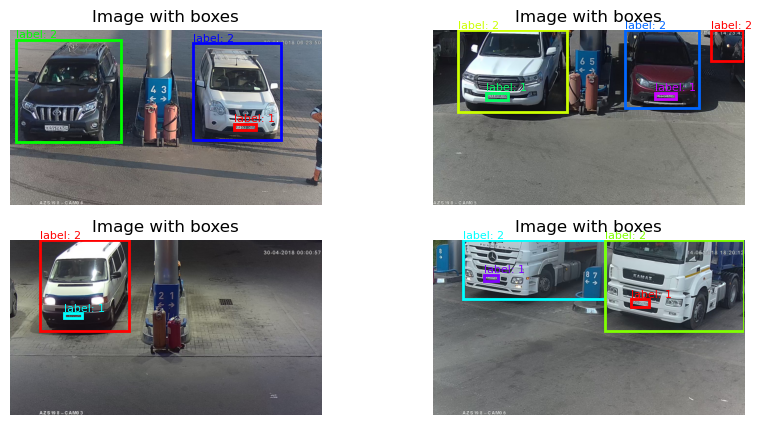

In [7]:
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])


fig, axes = plt.subplots(2, 2, figsize=(10, 5))


for ind, ax in enumerate(axes.flatten()):

    N = boxes[ind].shape[0]
    colors = random_colors(N)
    bbox = boxes[ind].cpu().detach().numpy()
    label = labels[ind].cpu().detach().numpy()

    image = std*images[ind].permute(1, 2, 0).cpu().detach() + torch.tensor([0.485, 0.456, 0.406])
    image = image.numpy()[:,:,::-1]
    visualize(image, 
              bbox, 
              label,
              scores=None, 
              ax=ax,
              colors=colors)
    
plt.show()

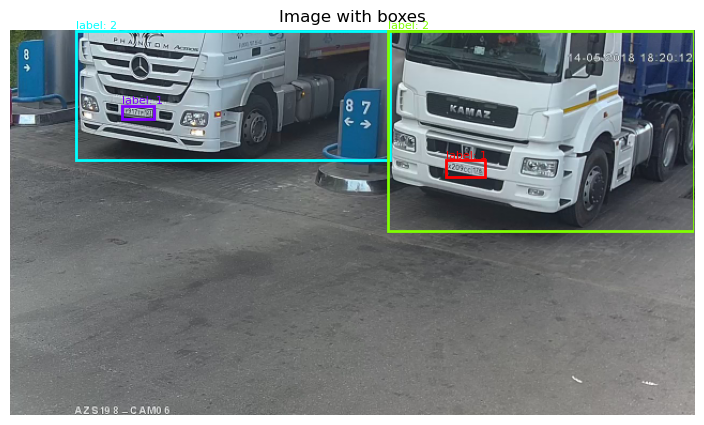

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

visualize(image, 
          bbox, 
          label,
          scores=None, 
          ax=axes,
          colors=colors
          )
plt.show()

## Разработать функцию вычисление mAP метрики задачи детектирования

In [9]:
true_labels =[torch.tensor([2, 2, 2, 2, 2, 1, 1, 2], dtype=torch.int32)]

true_boxes = [torch.tensor([
                [0.1445, 0.0958, 0.3688, 0.5083],
                [0.5570, 0.0181, 0.7422, 0.2403],
                [0.9133, 0.0500, 0.9992, 0.5250],
                [0.8406, 0.0000, 0.9992, 0.3000],
                [0.6000, 0.1042, 0.8688, 0.5736],
                [0.2164, 0.4333, 0.2844, 0.4597],
                [0.7234, 0.4528, 0.7914, 0.4861], 
                [0.0016, 0.0000, 0.1625, 0.2514]],
                dtype=torch.float64)]

pred_labels, pred_boxes, scores = [torch.tensor([2]), torch.tensor([1]), torch.tensor([0])], \
    [
    torch.tensor([[-0.0036,  0.0015,  0.1612,  0.2483]]),
    torch.tensor([[0.7234, 0.4528, 0.7914, 0.4861]]),
    torch.tensor([[0, 0, 0, 0]]),
    ], [torch.tensor([0.9]), torch.tensor([0.1]), torch.tensor([0.0])]



In [10]:
def AP(true_labels, pred_labels, true_boxes, pred_boxes, scores, class_instance, treshold=0.8, device='cuda:0'):


    # -------------- PREPROCESSING -------------------------------

    true_labels = torch.concat(true_labels).clone().int()
    pred_labels = torch.concat(pred_labels).clone().int()
    true_boxes  = torch.concat(true_boxes).clone()
    pred_boxes  = torch.concat(pred_boxes).clone()

    scores      = torch.concat(scores).clone()

    # ------------------------------------------------------------

    # select class
    true_class_label = (true_labels == class_instance).int()
    pred_class_label = (pred_labels == class_instance).int()

    if torch.sum(true_class_label) == 0:
        return None


    # filtering by IOU 
    IOUs = jaccard(true_boxes, pred_boxes) 
    maxIOUS_values, maxIOUS_ind = IOUs.max(dim=0)
    treshold_maxIOUS_values = maxIOUS_values > treshold


    # select only relevant class
    relevant_class_ind = true_class_label[maxIOUS_ind].bool()
    pred_class_label_selected = pred_class_label[relevant_class_ind]
    proff_class = torch.ones_like(pred_class_label_selected) == pred_class_label_selected

    treshold_maxIOUS_values_selected = treshold_maxIOUS_values[relevant_class_ind]

    # create array with TP and FP
    prediction_tp_fp = treshold_maxIOUS_values_selected & proff_class

    # if all FP we know th answer
    if prediction_tp_fp.sum().item() == 0:
        return 0


    # sort values in descending order
    indices = scores[relevant_class_ind].argsort(axis = 0 ,descending=True ).int().clone()
    prediction_tp_fp = prediction_tp_fp[indices].int()
    
    # calculate precision - recall
    all_actual_positive = true_class_label.sum()
    recall = prediction_tp_fp.cumsum(dim=0) / all_actual_positive
    precision = prediction_tp_fp.cumsum(dim=0) / torch.arange(1, len(prediction_tp_fp)+1).to(device)


    # smoothing precision function
    precision_max = []
    curr_max = -np.inf

    for val in torch.flip(precision, [0]):
        if val > curr_max:
            curr_max = val.reshape(1)

        precision_max.append(curr_max)

    precision_max = precision_max[::-1]



    # calculate square under curve
    recall[1:] -= recall[:-1].clone()
    return torch.sum(torch.cat(precision_max) * recall).item()


In [11]:
for i in range(3):
    Average_Precision = AP(true_labels, pred_labels, true_boxes, pred_boxes, scores, class_instance=i, device='cpu')
    print(f'for class={i}, {Average_Precision=}')


for class=0, Average_Precision=None
for class=1, Average_Precision=0.5
for class=2, Average_Precision=0.1666666716337204


In [113]:
def mAP(true_labels, pred_labels, true_boxes, pred_boxes, scores, num_class=3, treshold=0.8, device='cuda:0'):
    _map = []
    for i in range(1, num_class):
        Average_Precision = AP(true_labels, pred_labels, true_boxes, pred_boxes, scores, class_instance=i, device=device, treshold=treshold)
        if Average_Precision is not None:
            _map.append(Average_Precision)
            
    return torch.mean(torch.tensor(_map).float()).item()

In [99]:
mAP(true_labels, pred_labels, true_boxes, pred_boxes, scores, device='cpu')

TypeError: concat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
def NMS(label, pred_boxes, scores, treshold = 0.5):
    sort_ind = scores[0].argsort(descending=True)
    sorted_boxes = pred_boxes[0][sort_ind]
    ious = jaccard(sorted_boxes, sorted_boxes) 

    ious = ious- torch.eye(ious.shape[0])
    ious_threshold = ious > treshold

    duplicates = []
    for ind, iou in enumerate(ious_threshold):
        dup = iou.nonzero(as_tuple=True)
        dup = dup[0].numpy().tolist()

        if ind not in duplicates:
            duplicates.extend(dup)

    nms_ind = torch.tensor(list(set(range(len(sort_ind))) - set(duplicates))).long()
    return [label[0][nms_ind]], [pred_boxes[0][nms_ind]], [scores[0][nms_ind]]

## Натренировать модель на основе VGG16

In [14]:
def train_process(custom_config, learning_config):
    torch.manual_seed(     learning_config['seed'])
    np.random.seed   (seed=learning_config['seed'])   
    
    dataset_root_dir          = learning_config['dataset_root_dir']
    train_annotation_filename = os.path.join( dataset_root_dir, "ImageSets/Main/trainval.txt" )
    test_annotation_filename  = os.path.join( dataset_root_dir, "ImageSets/Main/test.txt"     )
    train_dataloader          = get_train_dataloader(dataset_root_dir, train_annotation_filename, learning_config['batch_size'], learning_config['num_workers'])
    test_dataloader           = get_test_dataloader (dataset_root_dir, test_annotation_filename , 1, learning_config['num_workers'])
    

    os.makedirs(learning_config['output'], exist_ok=True)

    
    if learning_config['resnet18']:
        model = SSD_ResNet18(custom_config['num_priors'], custom_config['num_classes'])
    else:
        model = SSD_VGG16(custom_config['num_priors'], custom_config['num_classes'])

    if learning_config['log_online']:
    
        wandb.login(key="cfedead01b64744b86b1cc0779b5ab7c10fc942f")
        wandb.init(
            project=learning_config['project_name'],
            name=custom_config['model_name'],
            reinit=True,
            config=learning_config,
        )
    
    prior_box_s = prior_boxes(custom_config)
    prior_box_s_gpu = prior_box_s.cuda()
    
    overlap_threshold = custom_config['overlap_threshold']
    neg_pos_ratio     = custom_config['neg_pos_ratio'    ]
    variance          = custom_config['variance']

    criterion = MultiBoxLoss(overlap_threshold, neg_pos_ratio, variance)
    model.cuda()
    criterion.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=learning_config['learning_rate'], 
                                momentum=learning_config['momentum'], 
                                weight_decay=learning_config['weight_decay'])

    scheduler = MultiStepLR(optimizer=optimizer, milestones=learning_config['multistep'], gamma=0.2)
    
    best_loc_loss, best_cls_loss, best_loss = np.inf, np.inf, np.inf

    for epoch in list(range(learning_config['epochs'])):

        start = time.time()
        #Train model
        train_loc_loss, train_cls_loss, train_loss = 0, 0, 0
        model.train()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            image_s_gpu  = image_s_cpu.cuda()
            label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
            box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]
            
            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

           
            loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
            loss = loc_loss + cls_loss
            
            optimizer.zero_grad()
            loss     .backward()
            optimizer.step()
            
            train_loc_loss += loc_loss.item()
            train_cls_loss += cls_loss.item()
            train_loss     += loss    .item()
            

            del image_s_gpu
            del label_ss_gpu
            del box_ss_gpu

        if learning_config['log_online']:

            wandb.log({
                "TRAIN local loss":  train_loc_loss, 
                "TRAIN class loss":  train_cls_loss, 
                "TRAIN loss":        train_loss,
                })

        scheduler.step()
        
        #Eval model
        imitate_train_dataloader= get_test_dataloader (dataset_root_dir, train_annotation_filename , 1, 1)
        val_mAP = []
        train_mAP = []

        eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
        model.eval()

        for ind_loader, loader in enumerate([imitate_train_dataloader, test_dataloader]):
            for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in tqdm(enumerate(loader), total=len(loader)):
                image_s_gpu = image_s_cpu.cuda()
                label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]
                
                pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)
                
                loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
                loss = loc_loss + cls_loss
                
                eval_loc_loss += loc_loss.item()
                eval_cls_loss += cls_loss.item()
                eval_loss     += loss    .item()


                # ------------------------- Calculate mAP -------------------------

                pred_boxes, pred_labels, scores = detect_objects_bboxes(pred_loc_ss_gpu.clone(), pred_conf_ss_gpu.clone(), 
                                                                        min_score=0.05, max_overlap=0.8, top_k=6,
                                                                        cfg=custom_config)


                mAP_metric = mAP(label_ss_gpu, pred_labels, box_ss_gpu, pred_boxes, scores)

                if ind_loader == 0:
                    train_mAP.append(mAP_metric)
                else:
                    val_mAP.append(mAP_metric)
                # ------------------------- Calculate mAP -------------------------

                del image_s_gpu
                del label_ss_gpu
                del box_ss_gpu

        if learning_config['log_online']:

            wandb.log({
                "VALIDATION local loss":  eval_loc_loss, 
                "VALIDATION class loss":  eval_cls_loss, 
                "VALIDATION loss":        eval_loss,
                "Train mAP":              np.mean(train_mAP),
                "VALIDATION mAP":         np.mean(val_mAP),
                })
            
        print('epoch [{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}]'.format(\
            epoch, scheduler.get_last_lr()[0], train_loc_loss, eval_loc_loss, train_cls_loss, eval_cls_loss, train_loss, eval_loss))
        print('Train mAP: {:.4f}, Validation mAP: {:.4f}'.format(np.mean(train_mAP), np.mean(val_mAP)))
        
        _time = (time.time()-start) / 60
        print('Time in min.: {:.2f}\n'.format(_time))

        if eval_loss < best_loss :
            torch.save(model.state_dict(), os.path.join(learning_config['output'], f"{custom_config['model_name']}.pth"))
            best_loc_loss, best_cls_loss, best_loss = eval_loc_loss, eval_cls_loss, eval_loss

    del model

### Train model

In [15]:
custom_config = {
        'num_classes'  : 3,
        'feature_maps' : [(45, 80), (22, 40), (11, 20), (6, 10), (4, 8), (2, 6)], # VGG16
        'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
        'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],
        
        'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
        'num_priors'   : [6, 6, 6, 6, 4, 4],
        'variance'     : [0.1, 0.2],
        'clip'         :    True,
        
        'overlap_threshold': 0.5, 
        'neg_pos_ratio'    :   3,

        'model_name' : 'vgg16'
        }

In [16]:
learning_config={
    'resnet18':          False,
    'seed':              42,

    'learning_rate':     1e-3,
    'momentum':          0.9,
    'weight_decay':      5e-4,
    'multistep':        [20, 40, 60],
    'epochs':            50,
    'batch_size':        16,

    'num_workers':       1,

    'log_online':        True,
    
    'output':           'output',
    'dataset_root_dir': 'dataset',
    'output_dir_eval':   './output/eval',

    'project_name':      "ML3_obj_detect"
}

In [17]:
train_process(custom_config, learning_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: julia-kudr-alex (juliakudryavtseva). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\julia/.netrc


100%|██████████| 272/272 [00:15<00:00, 17.59it/s]


epoch [0] | lr 0.00100 | loc_loss [437.36/4064.38] | cls_loss [834.43/8717.10] | total_loss [1271.79/12781.48]
Train mAP: 0.2009, Validation mAP: 0.1895
Time in min.: 11.65



100%|██████████| 272/272 [00:14<00:00, 18.33it/s]


epoch [1] | lr 0.00100 | loc_loss [210.12/2918.64] | cls_loss [471.26/7408.75] | total_loss [681.38/10327.40]
Train mAP: 0.2136, Validation mAP: 0.1976
Time in min.: 24.28



100%|██████████| 272/272 [00:15<00:00, 17.82it/s]


epoch [2] | lr 0.00100 | loc_loss [166.24/2501.43] | cls_loss [419.67/6786.40] | total_loss [585.91/9287.83]
Train mAP: 0.2171, Validation mAP: 0.1970
Time in min.: 36.09



100%|██████████| 272/272 [00:15<00:00, 17.80it/s]


epoch [3] | lr 0.00100 | loc_loss [143.71/2101.88] | cls_loss [389.36/6299.21] | total_loss [533.07/8401.10]
Train mAP: 0.2195, Validation mAP: 0.1986
Time in min.: 56.45



100%|██████████| 272/272 [00:15<00:00, 17.69it/s]


epoch [4] | lr 0.00100 | loc_loss [128.38/2128.92] | cls_loss [368.56/6106.98] | total_loss [496.95/8235.90]
Train mAP: 0.2160, Validation mAP: 0.1948
Time in min.: 71.32



100%|██████████| 272/272 [00:14<00:00, 18.39it/s]


epoch [5] | lr 0.00100 | loc_loss [117.45/1842.24] | cls_loss [353.20/5841.06] | total_loss [470.65/7683.30]
Train mAP: 0.2209, Validation mAP: 0.2041
Time in min.: 89.65



100%|██████████| 272/272 [00:15<00:00, 17.74it/s]


epoch [6] | lr 0.00100 | loc_loss [110.37/1705.18] | cls_loss [341.65/5605.49] | total_loss [452.02/7310.67]
Train mAP: 0.2215, Validation mAP: 0.2059
Time in min.: 100.66



100%|██████████| 272/272 [00:14<00:00, 18.33it/s]


epoch [7] | lr 0.00100 | loc_loss [103.64/1612.67] | cls_loss [330.68/5428.16] | total_loss [434.32/7040.83]
Train mAP: 0.2226, Validation mAP: 0.2041
Time in min.: 113.29



100%|██████████| 272/272 [00:14<00:00, 18.47it/s]


epoch [8] | lr 0.00100 | loc_loss [98.34/1491.19] | cls_loss [321.67/5363.23] | total_loss [420.01/6854.42]
Train mAP: 0.2229, Validation mAP: 0.2056
Time in min.: 128.11



100%|██████████| 272/272 [00:15<00:00, 18.10it/s]


epoch [9] | lr 0.00100 | loc_loss [94.32/1406.49] | cls_loss [313.60/5184.62] | total_loss [407.91/6591.11]
Train mAP: 0.2257, Validation mAP: 0.2087
Time in min.: 142.86



100%|██████████| 272/272 [00:15<00:00, 18.09it/s]


epoch [10] | lr 0.00100 | loc_loss [89.59/1323.87] | cls_loss [305.27/4993.40] | total_loss [394.87/6317.27]
Train mAP: 0.2260, Validation mAP: 0.2078
Time in min.: 159.33



100%|██████████| 272/272 [00:14<00:00, 18.68it/s]


epoch [11] | lr 0.00100 | loc_loss [86.34/1330.03] | cls_loss [298.21/4786.29] | total_loss [384.54/6116.33]
Train mAP: 0.2263, Validation mAP: 0.2114
Time in min.: 169.73



100%|██████████| 272/272 [00:32<00:00,  8.46it/s]


epoch [12] | lr 0.00100 | loc_loss [83.22/1248.90] | cls_loss [290.78/4711.89] | total_loss [374.00/5960.79]
Train mAP: 0.2274, Validation mAP: 0.2096
Time in min.: 183.36



100%|██████████| 272/272 [00:15<00:00, 18.10it/s]


epoch [13] | lr 0.00100 | loc_loss [80.84/1295.78] | cls_loss [285.54/4828.05] | total_loss [366.38/6123.83]
Train mAP: 0.2260, Validation mAP: 0.2114
Time in min.: 202.48



100%|██████████| 272/272 [00:14<00:00, 18.38it/s]


epoch [14] | lr 0.00100 | loc_loss [77.91/1257.44] | cls_loss [278.19/4578.78] | total_loss [356.10/5836.21]
Train mAP: 0.2272, Validation mAP: 0.2142
Time in min.: 212.88



100%|██████████| 272/272 [00:42<00:00,  6.47it/s]


epoch [15] | lr 0.00100 | loc_loss [75.42/1190.08] | cls_loss [272.45/4458.43] | total_loss [347.88/5648.51]
Train mAP: 0.2282, Validation mAP: 0.2087
Time in min.: 231.56



100%|██████████| 272/272 [00:39<00:00,  6.92it/s]


epoch [16] | lr 0.00100 | loc_loss [73.20/1136.39] | cls_loss [265.72/4359.33] | total_loss [338.92/5495.72]
Train mAP: 0.2289, Validation mAP: 0.2096
Time in min.: 246.86



100%|██████████| 272/272 [00:38<00:00,  7.06it/s]


epoch [17] | lr 0.00100 | loc_loss [71.34/1054.26] | cls_loss [258.89/4262.10] | total_loss [330.24/5316.36]
Train mAP: 0.2298, Validation mAP: 0.2133
Time in min.: 269.06



100%|██████████| 272/272 [00:35<00:00,  7.74it/s]


epoch [18] | lr 0.00100 | loc_loss [69.38/1051.36] | cls_loss [253.67/4393.38] | total_loss [323.05/5444.74]
Train mAP: 0.2288, Validation mAP: 0.2114
Time in min.: 291.74



100%|██████████| 272/272 [00:39<00:00,  6.88it/s]


epoch [19] | lr 0.00020 | loc_loss [68.04/1047.02] | cls_loss [248.40/4140.73] | total_loss [316.43/5187.74]
Train mAP: 0.2305, Validation mAP: 0.2142
Time in min.: 312.17



100%|██████████| 272/272 [00:15<00:00, 17.86it/s]


epoch [20] | lr 0.00020 | loc_loss [58.12/896.21] | cls_loss [229.54/3904.49] | total_loss [287.66/4800.71]
Train mAP: 0.2304, Validation mAP: 0.2105
Time in min.: 331.58



100%|██████████| 272/272 [00:14<00:00, 18.84it/s]


epoch [21] | lr 0.00020 | loc_loss [57.28/899.47] | cls_loss [226.66/3865.07] | total_loss [283.95/4764.53]
Train mAP: 0.2307, Validation mAP: 0.2105
Time in min.: 348.99



100%|██████████| 272/272 [00:15<00:00, 17.79it/s]


epoch [22] | lr 0.00020 | loc_loss [56.72/913.95] | cls_loss [223.87/3893.67] | total_loss [280.59/4807.62]
Train mAP: 0.2302, Validation mAP: 0.2151
Time in min.: 359.39



100%|██████████| 272/272 [00:15<00:00, 17.97it/s]


epoch [23] | lr 0.00020 | loc_loss [56.64/886.65] | cls_loss [223.01/3788.30] | total_loss [279.65/4674.96]
Train mAP: 0.2312, Validation mAP: 0.2124
Time in min.: 370.09



100%|██████████| 272/272 [00:14<00:00, 18.65it/s]


epoch [24] | lr 0.00020 | loc_loss [56.41/875.90] | cls_loss [221.70/3806.19] | total_loss [278.11/4682.08]
Train mAP: 0.2313, Validation mAP: 0.2105
Time in min.: 388.64



  1%|          | 3/364 [00:04<08:42,  1.45s/it]


KeyboardInterrupt: 

### Evaluate model

In [17]:
checkpoint_path =  f"./output/{custom_config['model_name']}.pth"
device = 'cuda'

model = SSD_VGG16(custom_config['num_priors'], custom_config['num_classes'])
model.load_state_dict(torch.load(checkpoint_path, map_location=None if torch.cuda.is_available() else 'cpu'))
model.to('cuda:0')


SSD_VGG16(
  (norm_layer): L2Norm()
  (total_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [286]:
def save_image(img, pred_boxes, pred_labels, scores, 
               true_boxes, true_labels,
               map, 
               save_path, name):
    
    pred_boxes = torch.concat(pred_boxes)
    true_boxes = torch.concat(true_boxes)

    true_labels = torch.concat(true_labels)
    pred_labels = torch.concat(pred_labels)

    scores = torch.concat(scores).cpu().numpy()


    img = 0.25 * img[0].permute(1, 2, 0) + 0.5
    img = img.numpy()[:,:,::-1]

    map = round(map, 4)


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    visualize(img, 
            pred_boxes, 
            pred_labels,
            scores=scores, 
            ax=axes[0],
            colors=[(1.0, 0.0, 0.0)] * len(pred_labels),
            title=f'mAP: {map}',
            )
    
    visualize(img, 
            true_boxes, 
            true_labels,
            scores=None, 
            ax=axes[1],
            colors=[(0.0, 1.0, 0.0)] * len(true_labels),
            )
    
    path_to_save = os.path.join(save_path , name +'.png')
#     plt.savefig(path_to_save)
    plt.show()


In [413]:
def eval_model(model, learning_config, detailed=False, draw=False, draw_number=5,  treshold=0.8):

    test_dataloader  = get_test_dataloader(voc_root, test_annotation_filename, 1, 1) # set num_works to 1 due to windows
    eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
    model.eval()
    mAP_results = []

    for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
        image_s_gpu = image_s_cpu.cuda()
        label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
        box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]
        
        with torch.no_grad():
            pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

        pred_boxes, pred_labels, scores = detect_objects_bboxes(pred_loc_ss_gpu, pred_conf_ss_gpu, 
                                        min_score=0.05, max_overlap=0.8, top_k=6,
                                        cfg=custom_config)
        
        pred_labels  = [ pred_label.cpu() for pred_label in pred_labels ]
        pred_boxes   = [ pred_boxe .cpu() for pred_boxe   in pred_boxes   ]
        scores       = [ score.cpu() for score in scores ]


        pred_labels, pred_boxes, scores = NMS(pred_labels, pred_boxes, scores, treshold=treshold)
        
        mAP_metric = mAP(label_ss_cpu, pred_labels, box_ss_cpu, pred_boxes, scores, device='cpu',  treshold=treshold)
        mAP_results.append(mAP_metric)


        
        
        if draw:
            save_image(image_s_cpu, pred_boxes, pred_labels, scores, 
                       box_ss_cpu, label_ss_cpu, 
                       mAP_metric, 
                       learning_config['output_dir_eval'], str(i))

        
        del image_s_gpu
        del label_ss_gpu
        del box_ss_gpu

        if i > draw_number:
            break

    return np.mean(mAP_results) if not detailed else mAP_results


In [414]:
avr_mAP = eval_model(model, learning_config)
print(f'mAP averaged by Images: {avr_mAP}')

mAP averaged by Images: 0.3523809516004154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


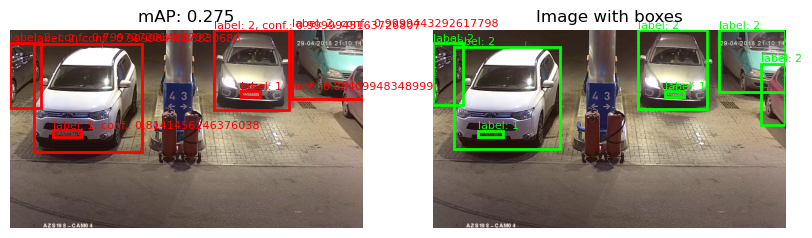

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


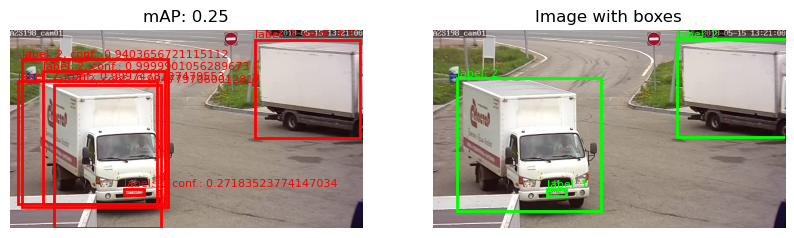

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


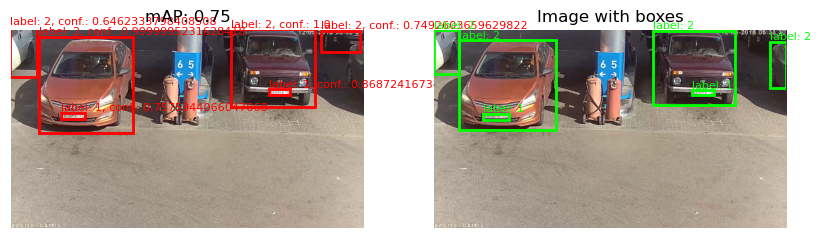

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


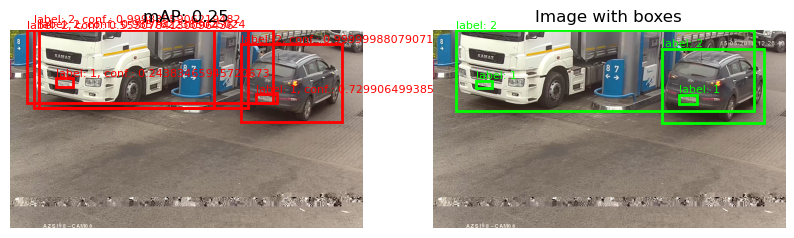

TypeError: cannot unpack non-iterable numpy.float64 object

In [415]:
label_ss_cpu, pred_labels, box_ss_cpu, pred_boxes, scores = eval_model(model, learning_config, draw=True, draw_number=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


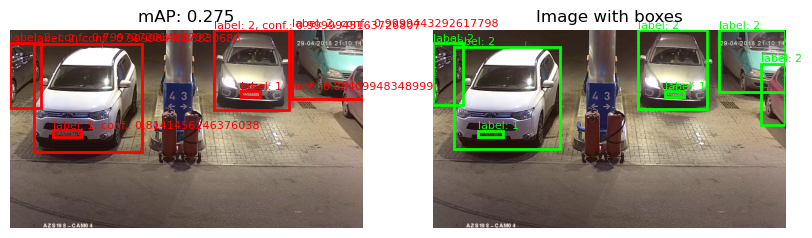

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


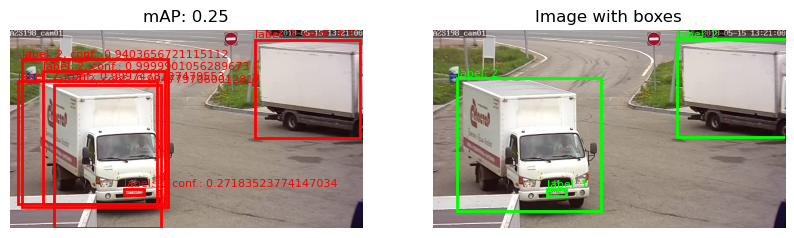

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


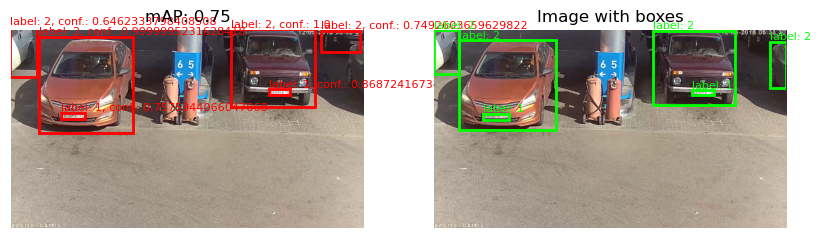

0.4250000019868215

In [373]:
eval_model(model, learning_config, draw=True, draw_number=1)

## Разработать модель на основе ResNet18

In [18]:
class SSD_ResNet18(nn.Module):
    def __init__(self, num_bboxes_s, num_labels=3):
        super().__init__()

        self.num_labels = num_labels
        self.num_bboxes_s = num_bboxes_s

        self.used_layer_id_s = list(range(7, 13))
                
        base_layers       = self._build_base_layers ()
        extra_layers      = self._build_extra_layers()
        self.total_layers = base_layers + extra_layers

        self.conf_layers, self.loc_layers = self._build_conf_loc_layers()
        
    def _build_base_layers(self):
        backbone_model    = models.resnet18(weights=ResNet18_Weights.DEFAULT)  #False

        drop_layers = ['layer4', 'avgpool', 'fc']
        base_layers = [layer for name, layer in backbone_model.named_children() if name not in drop_layers]

        conv256 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)

        init.xavier_uniform_(conv256.weight)
        init.zeros_         (conv256  .bias)


        basic_layer = copy.deepcopy(getattr(backbone_model, 'layer2'))
        basic_layer[0].conv1 = conv256
        basic_layer[0].downsample[0] = copy.deepcopy(conv256)
        base_layers.append(basic_layer)

        return nn.ModuleList(base_layers)

    def _build_extra_layers(self, number_blocks=5):
        extra_layers = []

        conv1 = nn.Conv2d(128, 64, kernel_size=1, stride=1            )
        relu1 = nn.ReLU(inplace=True)
        conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1 )
        relu2 = nn.ReLU(inplace=True)
        
        init.xavier_uniform_(conv1 .weight)
        init.zeros_         (conv1 .bias  )
        init.xavier_uniform_(conv2 .weight)
        init.zeros_         (conv2 .bias  )
        
        extra_layers = nn.Sequential(conv1, relu1, conv2, relu2)

        return [extra_layers for _ in range(number_blocks)]
    
    def _build_conf_loc_layers(self):
        
        conf_layers, loc_layers = [], []
        for i, j in enumerate(self.used_layer_id_s):

            if j > 7:
                _out_channels = self.total_layers[j][2].out_channels
            else:
                _out_channels =  self.total_layers[j][1].conv2.out_channels

            conf_layer = nn.Conv2d( _out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
            loc_layer  = nn.Conv2d( _out_channels, self.num_bboxes_s[i] * 4              , kernel_size=3, padding=1)
            
            init.xavier_uniform_(conf_layer.weight)
            init.zeros_         (conf_layer  .bias)
            init.xavier_uniform_(loc_layer .weight)
            init.zeros_         (loc_layer   .bias)
            
            conf_layers += [conf_layer]
            loc_layers  += [loc_layer ]

        conf_layers = nn.ModuleList(conf_layers)
        loc_layers  = nn.ModuleList(loc_layers )
        
        return conf_layers, loc_layers
    
    def forward(self, x):
        source_s, loc_s, conf_s = [], [], []
        
        for i, current_layer in enumerate(self.total_layers):
            x = current_layer(x)
            if i > 6:
                source_s.append(x)
                
        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s .append(l(s).permute(0, 2, 3, 1).contiguous())
        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s  = torch.cat([o.view(o.size(0), -1) for o in loc_s ], 1)
        
        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s  = loc_s .view(loc_s .size(0), -1, 4              )

        return loc_s, conf_s

## Натренировать модель на основе ResNet18

In [15]:
custom_config = {
        'num_classes'  : 3,
        'feature_maps' : [(23, 40), (12, 20), (6, 10), (3, 5), (2, 3), (1, 2)], 
        'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
        'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],
        
        'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [1, 2]],
        'num_priors'   : [6, 6, 6, 6, 6, 6],
        'variance'     : [0.1, 0.2],
        'clip'         :    True,
        
        'overlap_threshold': 0.5, 
        'neg_pos_ratio'    :   3,

        'model_name' : 'resnet18'
        }

In [16]:
learning_config={
    'resnet18':          True,
    'seed':              42,

    'learning_rate':     1e-3,
    'momentum':          0.9,
    'weight_decay':      5e-4,
    'multistep':        [20, 40, 60],
    'epochs':            30,
    'batch_size':        16,

    'num_workers':       1,

    'log_online':        True,
    
    'output':            'output',
    'dataset_root_dir':  'dataset',
    'output_dir_eval':   './output/eval',

    'project_name':      "ML3_obj_detect"
}


In [20]:
train_process(custom_config, learning_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: julia-kudr-alex (juliakudryavtseva). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\julia/.netrc


100%|██████████| 272/272 [00:41<00:00,  6.49it/s]


epoch [0] | lr 0.00100 | loc_loss [623.26/6171.95] | cls_loss [986.12/10650.44] | total_loss [1609.38/16822.39]
Train mAP: 0.3159, Validation mAP: 0.3554
Time in min.: 23.38



100%|██████████| 272/272 [00:35<00:00,  7.70it/s]


epoch [1] | lr 0.00100 | loc_loss [275.06/3913.04] | cls_loss [548.58/8720.61] | total_loss [823.64/12633.65]
Train mAP: 0.4655, Validation mAP: 0.4548
Time in min.: 17.69



100%|██████████| 272/272 [00:13<00:00, 20.78it/s]


epoch [2] | lr 0.00100 | loc_loss [198.95/3217.64] | cls_loss [473.42/7971.19] | total_loss [672.37/11188.83]
Train mAP: 0.5211, Validation mAP: 0.4804
Time in min.: 14.82



100%|██████████| 272/272 [00:17<00:00, 15.97it/s]


epoch [3] | lr 0.00100 | loc_loss [166.58/2685.80] | cls_loss [434.14/7330.13] | total_loss [600.72/10015.93]
Train mAP: 0.5587, Validation mAP: 0.5151
Time in min.: 6.23



100%|██████████| 272/272 [00:26<00:00, 10.20it/s]


epoch [4] | lr 0.00100 | loc_loss [146.08/2340.92] | cls_loss [406.17/6890.56] | total_loss [552.25/9231.48]
Train mAP: 0.5955, Validation mAP: 0.5475
Time in min.: 8.92



100%|██████████| 272/272 [00:22<00:00, 11.90it/s]


epoch [5] | lr 0.00100 | loc_loss [131.94/2126.37] | cls_loss [383.52/6566.12] | total_loss [515.45/8692.49]
Train mAP: 0.6013, Validation mAP: 0.5657
Time in min.: 17.24



100%|██████████| 272/272 [00:25<00:00, 10.82it/s]


epoch [6] | lr 0.00100 | loc_loss [119.49/1985.34] | cls_loss [362.06/6216.16] | total_loss [481.55/8201.51]
Train mAP: 0.6060, Validation mAP: 0.5641
Time in min.: 16.26



100%|██████████| 272/272 [00:27<00:00,  9.99it/s]


epoch [7] | lr 0.00100 | loc_loss [112.29/1756.91] | cls_loss [345.84/5896.41] | total_loss [458.13/7653.32]
Train mAP: 0.6359, Validation mAP: 0.5833
Time in min.: 16.76



100%|██████████| 272/272 [00:21<00:00, 12.61it/s]


epoch [8] | lr 0.00100 | loc_loss [104.53/1687.54] | cls_loss [327.46/5488.39] | total_loss [431.99/7175.92]
Train mAP: 0.6505, Validation mAP: 0.6091
Time in min.: 16.64



100%|██████████| 272/272 [00:15<00:00, 18.13it/s]


epoch [9] | lr 0.00100 | loc_loss [99.10/1734.28] | cls_loss [312.88/5383.71] | total_loss [411.98/7117.99]
Train mAP: 0.6507, Validation mAP: 0.5705
Time in min.: 15.38



100%|██████████| 272/272 [00:23<00:00, 11.79it/s]


epoch [10] | lr 0.00100 | loc_loss [93.51/1753.12] | cls_loss [297.37/5220.20] | total_loss [390.88/6973.32]
Train mAP: 0.6467, Validation mAP: 0.5567
Time in min.: 15.09



100%|██████████| 272/272 [00:09<00:00, 29.40it/s]


epoch [11] | lr 0.00100 | loc_loss [88.98/1445.88] | cls_loss [283.30/4773.77] | total_loss [372.28/6219.64]
Train mAP: 0.6709, Validation mAP: 0.5901
Time in min.: 8.71



100%|██████████| 272/272 [00:09<00:00, 29.40it/s]


epoch [12] | lr 0.00100 | loc_loss [84.29/1351.27] | cls_loss [268.05/4487.02] | total_loss [352.34/5838.29]
Train mAP: 0.6847, Validation mAP: 0.5878
Time in min.: 5.12



100%|██████████| 272/272 [00:09<00:00, 29.93it/s]


epoch [13] | lr 0.00100 | loc_loss [80.25/1302.18] | cls_loss [254.10/4302.52] | total_loss [334.35/5604.70]
Train mAP: 0.6865, Validation mAP: 0.6120
Time in min.: 4.99



100%|██████████| 272/272 [00:08<00:00, 31.53it/s]


epoch [14] | lr 0.00100 | loc_loss [76.87/1259.78] | cls_loss [239.85/4120.75] | total_loss [316.72/5380.54]
Train mAP: 0.6886, Validation mAP: 0.5990
Time in min.: 4.86



100%|██████████| 272/272 [00:08<00:00, 30.33it/s]


epoch [15] | lr 0.00100 | loc_loss [73.67/1292.26] | cls_loss [226.48/4011.11] | total_loss [300.15/5303.37]
Train mAP: 0.6797, Validation mAP: 0.5797
Time in min.: 4.97



100%|██████████| 272/272 [00:08<00:00, 30.98it/s]


epoch [16] | lr 0.00100 | loc_loss [71.08/1173.75] | cls_loss [214.21/3647.05] | total_loss [285.30/4820.79]
Train mAP: 0.7010, Validation mAP: 0.6153
Time in min.: 4.88



100%|██████████| 272/272 [00:09<00:00, 29.83it/s]


epoch [17] | lr 0.00100 | loc_loss [68.33/1101.23] | cls_loss [200.97/3397.17] | total_loss [269.31/4498.40]
Train mAP: 0.7132, Validation mAP: 0.6088
Time in min.: 5.04



100%|██████████| 272/272 [00:08<00:00, 31.04it/s]


epoch [18] | lr 0.00100 | loc_loss [65.71/1219.80] | cls_loss [189.40/3455.61] | total_loss [255.11/4675.41]
Train mAP: 0.7090, Validation mAP: 0.6197
Time in min.: 5.01



100%|██████████| 272/272 [00:09<00:00, 30.07it/s]


epoch [19] | lr 0.00020 | loc_loss [64.47/1125.52] | cls_loss [178.94/3405.04] | total_loss [243.41/4530.56]
Train mAP: 0.7092, Validation mAP: 0.5959
Time in min.: 4.96



100%|██████████| 272/272 [00:09<00:00, 29.02it/s]


epoch [20] | lr 0.00020 | loc_loss [55.94/950.38] | cls_loss [155.24/2801.99] | total_loss [211.18/3752.36]
Train mAP: 0.7325, Validation mAP: 0.6203
Time in min.: 4.96



100%|██████████| 272/272 [00:09<00:00, 29.58it/s]


epoch [21] | lr 0.00020 | loc_loss [55.08/943.40] | cls_loss [149.53/2758.96] | total_loss [204.61/3702.36]
Train mAP: 0.7343, Validation mAP: 0.6154
Time in min.: 4.98



100%|██████████| 272/272 [00:08<00:00, 30.31it/s]


epoch [22] | lr 0.00020 | loc_loss [54.77/953.14] | cls_loss [146.68/2699.61] | total_loss [201.45/3652.75]
Train mAP: 0.7345, Validation mAP: 0.6177
Time in min.: 5.03



100%|██████████| 272/272 [00:08<00:00, 30.56it/s]


epoch [23] | lr 0.00020 | loc_loss [54.43/938.84] | cls_loss [143.44/2660.95] | total_loss [197.87/3599.79]
Train mAP: 0.7328, Validation mAP: 0.6044
Time in min.: 4.95



100%|██████████| 272/272 [00:09<00:00, 29.97it/s]


epoch [24] | lr 0.00020 | loc_loss [54.40/950.98] | cls_loss [140.57/2615.49] | total_loss [194.97/3566.48]
Train mAP: 0.7343, Validation mAP: 0.6157
Time in min.: 4.96



100%|██████████| 272/272 [00:08<00:00, 30.36it/s]


epoch [25] | lr 0.00020 | loc_loss [54.01/937.11] | cls_loss [137.91/2581.66] | total_loss [191.91/3518.77]
Train mAP: 0.7345, Validation mAP: 0.6067
Time in min.: 4.98



100%|██████████| 272/272 [00:09<00:00, 29.55it/s]


epoch [26] | lr 0.00020 | loc_loss [53.60/920.52] | cls_loss [135.24/2528.07] | total_loss [188.85/3448.58]
Train mAP: 0.7406, Validation mAP: 0.6226
Time in min.: 4.94



100%|██████████| 272/272 [00:09<00:00, 29.35it/s]


epoch [27] | lr 0.00020 | loc_loss [53.39/920.53] | cls_loss [132.93/2486.44] | total_loss [186.32/3406.96]
Train mAP: 0.7385, Validation mAP: 0.6173
Time in min.: 4.97



100%|██████████| 272/272 [00:09<00:00, 29.96it/s]


epoch [28] | lr 0.00020 | loc_loss [53.02/912.53] | cls_loss [130.94/2451.60] | total_loss [183.96/3364.13]
Train mAP: 0.7405, Validation mAP: 0.6063
Time in min.: 4.97



100%|██████████| 272/272 [00:08<00:00, 30.68it/s]

epoch [29] | lr 0.00020 | loc_loss [52.61/913.34] | cls_loss [127.77/2435.31] | total_loss [180.38/3348.65]
Train mAP: 0.7384, Validation mAP: 0.6046
Time in min.: 4.96



In [22]:
del model

In [19]:
checkpoint_path =  f"./output/{custom_config['model_name']}.pth"
device = 'cuda'

model = SSD_ResNet18(custom_config['num_priors'], custom_config['num_classes'])
model.load_state_dict(torch.load(checkpoint_path, map_location=None if torch.cuda.is_available() else 'cpu'))
model.to('cuda:0')


SSD_ResNet18(
  (total_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [418]:
avr_mAP = eval_model(model, learning_config, treshold=0.5)
print(f'mAP averaged by Images: {avr_mAP}')

mAP averaged by Images: [0.8999999761581421, 1.0, 0.84375, 0.75, 0.4999999701976776, 1.0, 0.875]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


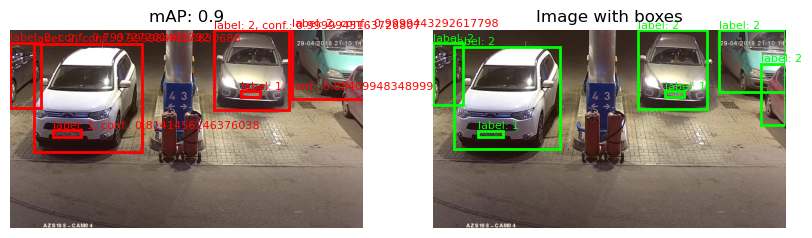

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


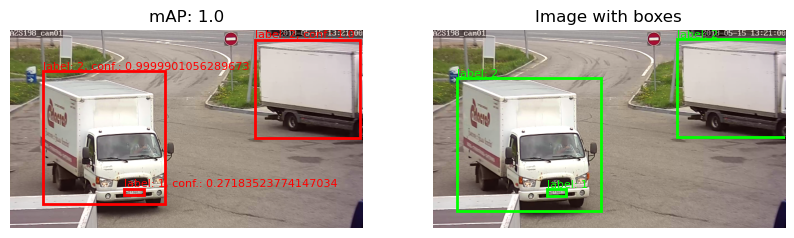

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


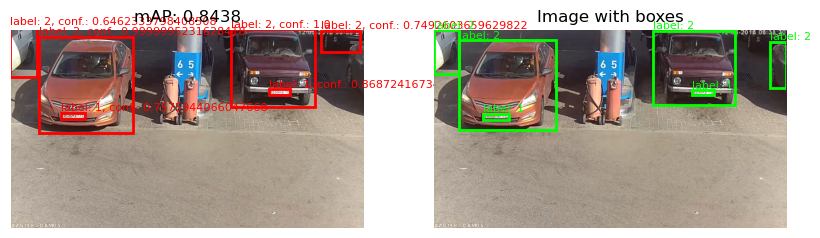

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


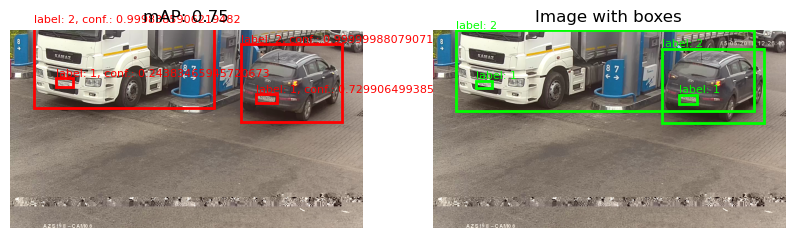

0.8734374940395355

In [422]:
eval_model(model, learning_config, draw=True, draw_number=2, treshold=0.5)

In [408]:
def NMS(label, pred_boxes, scores, treshold = 0.5):
    sort_ind = scores[0].argsort(descending=True)
    sorted_boxes = pred_boxes[0][sort_ind]
    ious = jaccard(sorted_boxes, sorted_boxes) 

    ious = ious- torch.eye(ious.shape[0])
    ious_threshold = ious > treshold

    duplicates = []
    for ind, iou in enumerate(ious_threshold):
        dup = iou.nonzero(as_tuple=True)
        dup = dup[0].numpy().tolist()

        if ind not in duplicates:
            duplicates.extend(dup)

    nms_ind = torch.tensor(list(set(range(len(sort_ind))) - set(duplicates))).long()
    return [label[0][nms_ind]], [pred_boxes[0][nms_ind]], [scores[0][nms_ind]]

## (БОНУС) Добавить разнообразные аугментации изображений в классе Dataset. Провести эксперименты и продемонстрировать метрику mAP.